# importing json file


import json per la llibreria que treballa amb json

In [1]:
import json
import numpy as np #aqui hi ha les estructures de dades que faig servir
import matplotlib.pyplot as plt #per dibuixar
import scipy.io as sio #el input output d'audio (wavfile.read)
from IPython.display import Audio #el reproductor d'audio
from numpy.fft import fft, ifft #podria fer numpy.fft en comptes de fer aquest import
from wav2vec import cutvowel, wav2vec #el nostre modul

importo el meu fitxer json

In [ ]:
with open("./vowels/jordi.json") as f:
    data = json.load(f)
print(data[30])

{'vocal': 'i', 'start': '5.65', 'end': '5.71'}


In [3]:
start = data[30]["start"]
end = data[30]["end"]
print(float(start))

5.65


les llibreries que necesito per utilitzar i processar audio

carrego el fitxer d'audio

In [ ]:
select = 5 #5 i 103
start = float(data[select]["start"])
end=float(data[select]["end"])

print(data[select], start, end)

Fs, audio = sio.wavfile.read("./vowels/jordi.wav")
#Fs, audio = cutvowel("vowels/alex.wav"), float(data[select]["start"]), float(data[select]["end"]))
print(Fs, int(start*Fs), int(end*Fs), len(audio))
cut = audio[int(start*Fs):int(end*Fs)]

#print(Fs)
#print(len(audio)) #per mirar si és estero o mono
#print(type(audio))
#print(type(audio[0]))

#start=4.4 #realment ho agafariem del fitxer json
#end=4.6

#framesentrada = int(float(start)*Fs) #calculem la mostra d'entrada
#framesalida = int(float(end)*Fs)
#cut=audio[framesentrada:framesalida] #retallem

#cut = audio
#data[select]["vocal"]
print(Fs)
print(cut)
print(len(cut))

{'vocal': 'a', 'start': '1.13', 'end': '1.19'} 1.13 1.19
48000 54239 57120 1388056
48000
[-11679 -10391  -8711 ...    567    376    191]
2881


In [13]:
Audio(cut, rate=Fs)

In [ ]:
def mostra2Freq(n_mostra, Fs, mostras_totals):
    return n_mostra * Fs / mostras_totals

def freq2Mostra(freq, Fs, mostras_totals):
    return freq * mostras_totals / Fs

dibuixem l'audio retallat

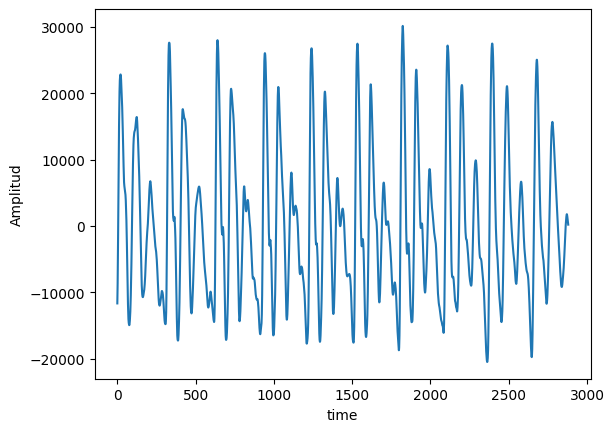

In [6]:
plt.figure()
plt.plot(cut)
plt.title("")
plt.xlabel("time")
plt.ylabel("Amplitud")
plt.show()

Dificil entendre algo. mirem fourier

/home/iticbnc/Documentos/course/ai/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/iticbnc/Documentos/course/ai/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


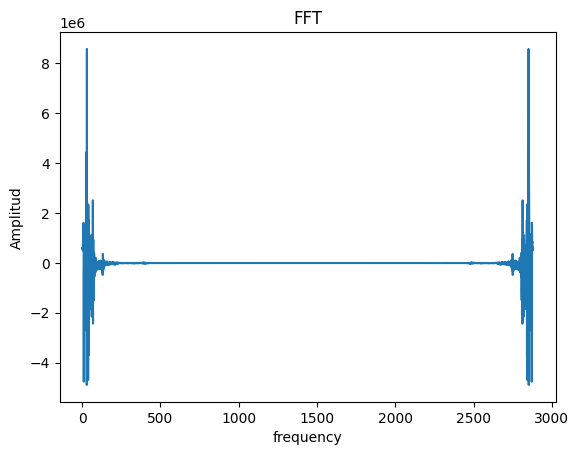

In [7]:
fourier = fft(cut)
plt.figure()
plt.plot(fourier)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("Amplitud")
plt.show()

només m'importa el que pasa a prop de zero

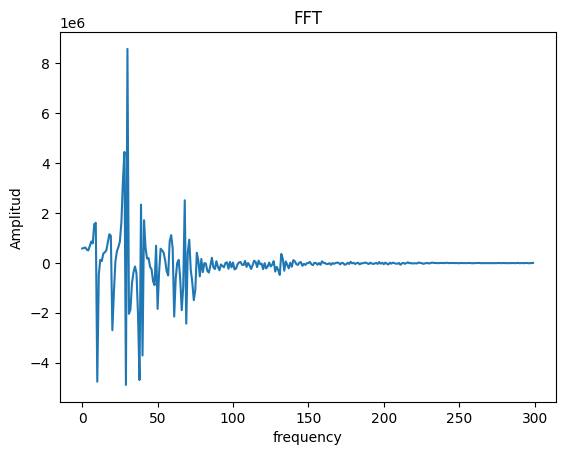

In [8]:
Fsmall = fourier[0:300]
plt.figure()
plt.plot(Fsmall)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("Amplitud")
plt.show()

No m'importa la fase, només el módul.


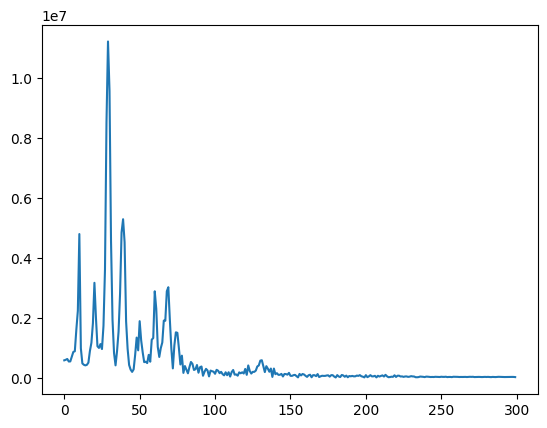

In [9]:
toprocess = np.sqrt((np.real(Fsmall)**2+np.imag(Fsmall)**2))
plt.figure()
plt.plot(toprocess)
plt.show()

Aplico un filtre per quedar eliminar soroll

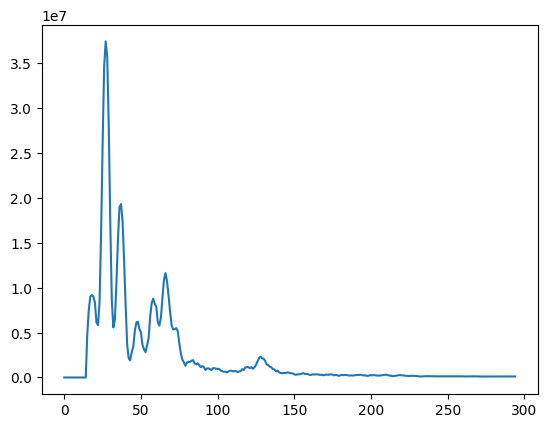

np.int64(27)

In [10]:
filter = 5
out = np.zeros(len(toprocess)-filter, dtype=np.float64)
for i in range(len(toprocess)-filter):
    for j in range(filter):
        out[i] += toprocess[i+j]

        
out[0:15] = 0
        
plt.figure()
plt.plot(out)
plt.show()

np.argmax(out)

27


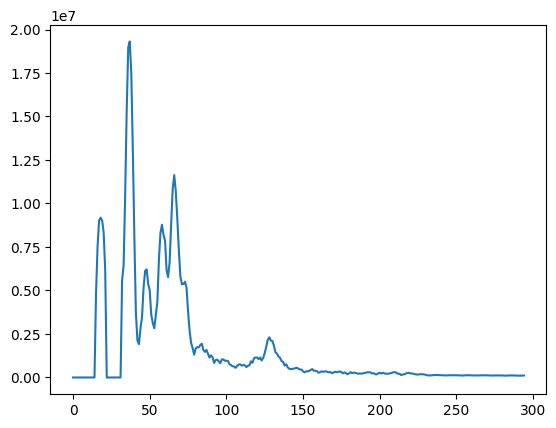

37


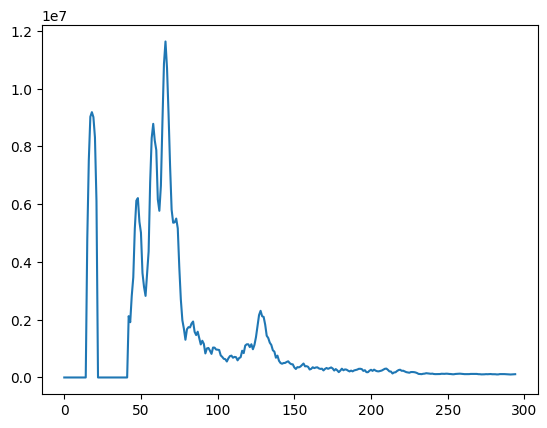

66


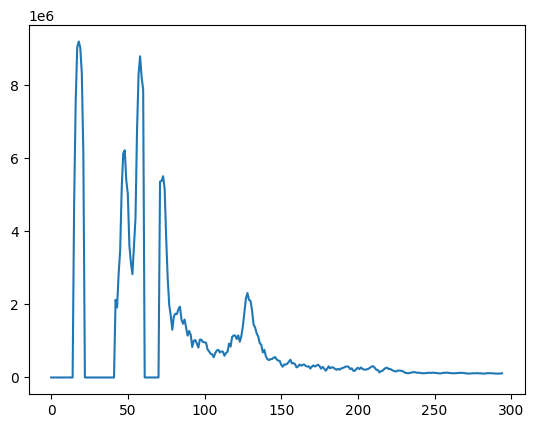

In [11]:
filter2 = 5

maxim1 = np.argmax(out)
print(maxim1)

filmin = filter2
if maxim1 < filter2:
    filmin = maxim1

out[maxim1-filmin:maxim1+filter2] = 0
plt.figure()
plt.plot(out)
plt.show()

maxim2 = np.argmax(out)
print(maxim2)

out[maxim2-filter2:maxim2+filter2] = 0
plt.figure()
plt.plot(out)
plt.show()


maxim3 = np.argmax(out)
print(maxim3)

out[maxim3-filter2:maxim3+filter2] = 0
plt.figure()
plt.plot(out)
plt.show()

In [12]:
print(fourier.size)
print(Fs)
print((maxim1)*Fs/fourier.size, "Hz")
print((maxim2)*Fs/fourier.size, "Hz")
print((maxim3)*Fs/fourier.size, "Hz")

2881
48000
449.84380423464074 Hz
616.452620617841 Hz
1099.6181881291218 Hz
